In [42]:
import pandas as pd
from pathlib import Path
import plotly.express as px

In [43]:
def get_single_year_abs_data(filepath):

    year = Path(filepath).stem[0:4]
    year_str = str(year)

    df_raw = pd.read_csv(
        filepath,
        header=6,
        names=["Postcode", "Fuel Type", "Vehicle Type", year_str],
        # dtype = {'Postcode': str, 'Fuel Type': str, 'Vehicle Type': str, year_str: int},
        # dtype=object,
        index_col=False,
        skipfooter=13,
        engine="python",
        # nrows=1000,
    )
    df = df_raw.copy()

    # fill nans
    df.fillna(method="ffill", axis=0, inplace=True)

    # drop rows from df where Postcode is #TOT or Total
    df.drop(df[df["Postcode"] == "#TOT"].index, inplace=True)
    df.drop(df[df["Postcode"] == "Total"].index, inplace=True)

    # ensure string type on this column
    df = df.astype({"Postcode": "int64"})
    df = df.astype({"Postcode": "string"})

    # ensure count is int type
    df = df.astype({year_str: "int64"})

    # add consistent leading zeros to postcodes
    df["Postcode"] = df["Postcode"].str.zfill(4)

    vehicle_type_mapping = {
        "Passenger Vehicles": "Passenger",
        "Light Commercial Vehicles": "Light Commercial",
    }
    for v in vehicle_type_mapping:
        df["Vehicle Type"] = df["Vehicle Type"].str.replace(v, vehicle_type_mapping[v])

    # pivot to make merging columns eaiser
    df = df.pivot(
        index=["Postcode", "Vehicle Type"], columns=["Fuel Type"], values=year_str
    )

    # combine petrol leaded and unleaded
    df["Petrol"] = df["Petrol leaded"] + df["Petrol unleaded"]
    df.drop(["Petrol leaded", "Petrol unleaded"], axis=1, inplace=True)

    # combine other and unknown
    unknown_col = "Unknown"
    if int(year) < 2018:
        unknown_col = "Other and unknown"

    df["Other"] = df["Other"] + df[unknown_col]
    df.drop([unknown_col], axis=1, inplace=True)

    df.rename({"LPG/Other gases": "LPG"}, axis=1, inplace=True)

    # combine LPG and Other into Other
    df["Other"] = df["LPG"] + df["Other"]
    # remove the LPG column
    df.drop(["LPG"], axis=1, inplace=True)

    # unpivot now that we are done
    df.reset_index(inplace=True)
    df = df.melt(
        id_vars=["Postcode", "Vehicle Type"], var_name="Fuel Type", value_name=year_str
    )

    # list of postcodes which are LVRs or PO boxes
    remove_postcodes = [
        (1000, 1999),
        (200, 299),
        (8000, 8999),
        (9000, 9999),
        (5800, 5999),
        (6800, 6999),
        (7800, 7999),
        (900, 999),
    ]
    for p in remove_postcodes:
        df.drop(df[(df["Postcode"].astype(int) >= p[0]) & (df["Postcode"].astype(int) <= p[1])].index, inplace=True)

    # rename the date column to include the month and day
    df.rename({year_str: year_str + "-01-31"}, axis=1, inplace=True)

    return df


In [44]:
df_2021 = get_single_year_abs_data("../data/raw/ABS/2021-abs-fuel-type-no-state.csv")
df_2020 = get_single_year_abs_data("../data/raw/ABS/2020-abs-fuel-type-no-state.csv")
df_2013 = get_single_year_abs_data("../data/raw/ABS/2013-aps-fuel-type-no-state.csv")
df_2013

/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(
/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(
/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(


,Postcode,Vehicle Type,Fuel Type,2013-01-31
0,0000,Light Commercial,Diesel,0
1,0000,Passenger,Diesel,0
6,0600,Light Commercial,Diesel,0
7,0600,Passenger,Diesel,0
8,0620,Light Commercial,Diesel,0
...,...,...,...,...
37553,7527,Passenger,Petrol,0
37554,7555,Light Commercial,Petrol,0
37555,7555,Passenger,Petrol,0
37556,7642,Light Commercial,Petrol,0


In [45]:
def get_state_from_postcode(postcode_string):
    # define the postcode ranges for each state
    state_to_postcode = {
        'NSW': [(2000, 2599), (2619, 2899), (2921, 2999)],
        'ACT': [(2600, 2618), (2900, 2920)],
        'VIC': [(3000, 3999)],
        'QLD': [(4000, 4999)],
        'SA':  [(5000, 5799)],
        'WA':  [(6000, 6798)], # added 6798 to WA
        'TAS': [(7000, 7799)],
        'NT':  [(800, 899)]
    }

    # convert the postcode string to an integer
    postcode = int(postcode_string)

    # loop over the states and their postcode ranges
    for state, ranges in state_to_postcode.items():
        for r in ranges:
            # if the provided postcode is within a range for a state, return that state
            if r[0] <= postcode <= r[1]:
                return state

    # if the postcode isn't within any of the ranges for any state, return None
    return 'AAA_NOSTATEFOUND'

In [46]:
def get_abs_data():
    files = sorted(Path("../data/raw/ABS").glob("*.csv"))
    return_df = pd.DataFrame()
    for f in files:
        df = get_single_year_abs_data(f)
        if not return_df.empty:
            return_df = return_df.merge(df, how="outer", on=["Postcode", "Vehicle Type","Fuel Type"])
        else:
            return_df = df
    
    return return_df

abs_df = get_abs_data()
abs_df = abs_df.dropna(subset=["2021-01-31"])

# add column for the state for each postcode
abs_df["State"] = abs_df["Postcode"].apply(get_state_from_postcode)
cols = list(abs_df.columns)
cols = [cols[-1]] + cols[:-1]
abs_df = abs_df[cols]

# write to csv
abs_df.to_csv("../data/processed/abs_df.csv", index=False)

/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(
/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(
/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(
/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_raw = pd.read_csv(
/var/folders/rd/12c6t5q92pv9swq7rhsy8m3w0000gr/T/ipykernel_72014/3661185702.py:6: Pa

In [47]:
abs_df

,State,Postcode,Vehicle Type,Fuel Type,2013-01-31,2014-01-31,2015-01-31,2016-01-31,2017-01-31,2018-01-31,2019-01-31,2020-01-31,2021-01-31
6,NT,0800,Light Commercial,Diesel,1303.0,1384.0,1413.0,1428.0,1633.0,1615.0,1565.0,1348.0,1478.0
7,NT,0800,Passenger,Diesel,957.0,1037.0,936.0,1010.0,1148.0,1289.0,1312.0,1109.0,1021.0
8,NT,0801,Light Commercial,Diesel,40.0,46.0,39.0,40.0,45.0,56.0,74.0,68.0,6.0
9,NT,0801,Passenger,Diesel,17.0,33.0,31.0,36.0,32.0,33.0,42.0,29.0,0.0
10,NT,0802,Light Commercial,Diesel,0.0,0.0,3.0,5.0,3.0,4.0,6.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34595,WA,6182,Passenger,Electric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
34596,WA,6182,Light Commercial,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
34597,WA,6182,Passenger,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
34598,WA,6182,Light Commercial,Petrol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [34]:
abs_df["Fuel Type"].unique()

array(['Diesel', 'Dual fuel', 'Electric', 'Other', 'Petrol'], dtype=object)

In [15]:
abs_long = abs_df.melt(id_vars=["Postcode","Vehicle Type","Fuel Type"], var_name="Year", value_name="Count")
fuel_type_df = abs_long.groupby(["Fuel Type", "Year"]).sum()
fuel_type_df.reset_index(inplace=True)

In [16]:
abs_df.groupby(['Fuel Type']).sum().diff(axis=1)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
# take difference across columns 2013 through 2021 of abs_df
abs_diff_df = abs_df.copy()
abs_diff_df.iloc[:,3:] = abs_df.iloc[:,3:].diff(axis=1)/12
abs_diff_df.drop(columns=["2013"], inplace=True)
nan_pc = [abs_df[c].isna().sum() / abs_df.shape[0] * 100 for c in abs_df.columns]
abs_diff_long = abs_diff_df.melt(id_vars=["Postcode","Vehicle Type","Fuel Type"], var_name="Year", value_name="Stock Change Per Month")
fuel_type_per_month_df = abs_diff_long.groupby(["Fuel Type", "Year"]).sum()
fuel_type_per_month_df.reset_index(inplace=True)
total_sales = fuel_type_per_month_df.groupby(['Year']).sum()
percent_of_count = [
    r['Stock Change Per Month'] / total_sales.loc[r['Year']]['Stock Change Per Month'] * 100
    for i, r in fuel_type_per_month_df.iterrows()
]
fuel_type_per_month_df['Percent'] = percent_of_count

In [ ]:
fig2 = px.area(fuel_type_per_month_df, x="Year", y='Percent', color='Fuel Type')
fig2.show()

In [ ]:
fuel_type_df

,Fuel Type,Year,Count
0,Diesel,2013,2275299.0
1,Diesel,2014,2567606.0
2,Diesel,2015,2845422.0
3,Diesel,2016,3119838.0
4,Diesel,2017,3411123.0
5,Diesel,2018,3709871.0
6,Diesel,2019,4024501.0
7,Diesel,2020,4287512.0
8,Diesel,2021,4522986.0
9,Dual fuel,2013,301277.0


In [ ]:
fig1 = px.area(fuel_type_df, x="Year", y='Count', color='Fuel Type', groupnorm='fraction')
fig1.show()


/tmp/ipykernel_166/4189909454.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_166/4189909454.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot: xlabel='Year'>

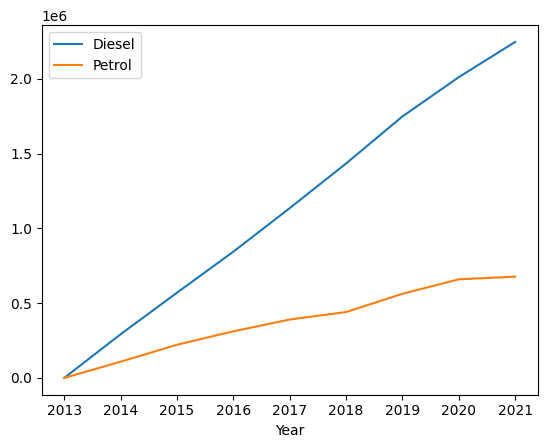

In [ ]:
d = fuel_type_df.loc[fuel_type_df['Fuel Type'] == 'Diesel']
d['Count'] = d['Count'] - d['Count'].iloc[0]
p = fuel_type_df.loc[fuel_type_df['Fuel Type'] == 'Petrol']
p['Count'] = p['Count'] - p['Count'].iloc[0]
ax = d.plot(x="Year", y="Count", label="Diesel")
p.plot(x="Year", y="Count", label="Petrol", ax=ax)

In [ ]:
(4.5-2.3)/(2021-2013)

0.275

In [ ]:
(13.45-12.8)/(2021-2013)

0.08124999999999982

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=75de7644-8bd4-4ecc-bdb2-2c9ef0ed94e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>